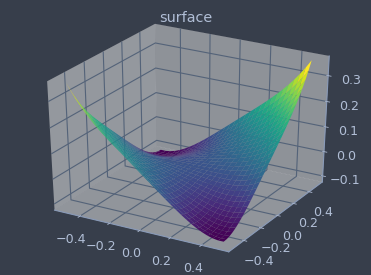

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

def f(x, y):
    return x**4 + y*np.sin(x) + y**4

x = np.linspace(-.5, .5, 30)
y = np.linspace(-.5, .5, 30)

X, Y = np.meshgrid(x, y)
Z = f(X, Y)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('surface');

In [88]:
def f(x):
    return x[0]**4 + x[1]*np.sin(x[0]) + x[1]**4

def get_gradient(x):
    return np.array([4*x[0]**3 - x[1]*np.cos(x[0]), 4*x[1]**3 + np.sin(x[0])])

def get_hessian(x):
    h = np.zeros(2,2)
    h[0,0] = 12*x[0]**2 - x[1]*np.sin(x[0])
    h[1,0] = 12*x[1]**2
    h[0,1] = -1*np.cos(x[0])
    h[1,1] = -1*np.cos(x[0])
    
    return h

#from https://stackoverflow.com/questions/16266720/find-out-if-matrix-is-positive-definite-with-numpy
def is_positive_definite(A):
    if np.array_equal(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

def armijo(x0, d, k):
    eta = 0.6
    gamma = 0.8
    t = 1

    while f(np.array(x0) + np.array(d)*t) > f(x0) + eta*t*np.dot(get_gradient(x0).transpose(), d):
        k += 1
        t = gamma*t

    return t, k

def gradient_method(x0):
    k = 0
    k_armijo = 0
    
    while get_gradient(x0).any():
        d = -1*get_gradient(x0)
        t, k_armijo = armijo(x0, d, k_armijo)
        x0 = np.array(x0) + t*d
        k += 1
        
        if (get_gradient(x0) == -1*d).all():
            print('delta == 0')
            return np.array([x0]), k, k_armijo

        if np.linalg.norm(get_gradient(x0)) <= 10**-15:
            print('gradient close to 0')
            return np.array([x0]), k, k_armijo
        
    return np.array(x0), k, k_armijo


print(gradient_method([-1.8385400365595483, 4.359940932133885]))
        

delta == 0
(array([[-0.69294073,  0.81352655]]), 124, 12018)


In [56]:
if  == 0:
    print('bvlah')

In [58]:
a = 1 
b = 2
c = np.array([2,1])
a,b = c

print(a,b)


2 1
